## 0.Imports

In [2]:
%matplotlib nbagg
#%matplotlib inline

from __future__ import absolute_import, division, print_function

#I/O
import sys
import os
import dm3_lib as dm3
import h5py
import pickle
from sklearn.externals import joblib

#graphics
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.gridspec as gridspec
import pylab as P


#processing 
import numpy as np
from scipy import fftpack
from scipy import ndimage

from skimage.feature import blob_log
from sklearn import cluster, mixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from collections import OrderedDict
from scipy.spatial import cKDTree

"""Our extraction and prediction & class activation map module"""
sys.path.append('..')
from defectfinder import extract_predict as exp
from defectfinder import classactmap as cmap

C:\Users\Sarthak\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import cv2
#neural networks
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Activation, Reshape
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K

### Read the image data from the movie

In [4]:
# Path to STEM video to be analysed
path = '.././'
filename = '60kV-0126.dm3'

dm3f = dm3.DM3(path + filename)
imgdata = dm3f.imagedata

Rescale the image and normalize it

In [4]:
for t in dm3f.tags:
    if 'PMTDF' in t:
        scale = float(dm3f.tags[t])/64000
        
imgdata = imgdata/scale
imgdata = imgdata - np.amin(imgdata)
imgdata = imgdata/np.amax(imgdata)

Creating a directory to save all the images

In [5]:
directory = '.././Figures/' + filename[:-4] + '/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [5]:
#first frame of the movie
imgsrc = imgdata[0]

<IPython.core.display.Javascript object>


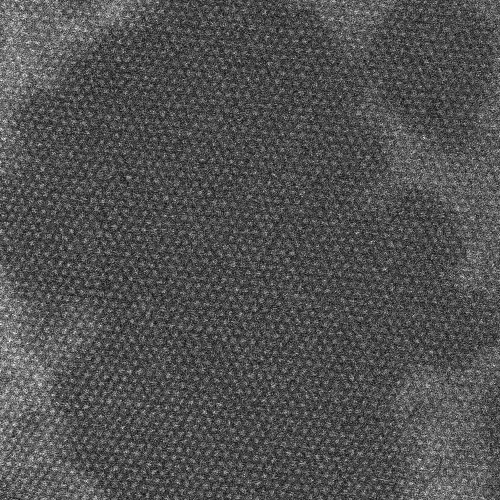

In [7]:
#plot real space image
fig100 = plt.figure(100, figsize=(5,5))
ax = fig100.add_axes([0, 0, 1, 1])
ax.imshow(imgsrc, cmap = 'gray')
ax.axis('off')

#save the figure
fig100.savefig(directory + filename + '_realspace.png')

In [8]:
# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

In [9]:
F2, F3 = exp.FFTmask(imgsrc, maskratio)

In [10]:
diff = exp.FFTsub(imgsrc, F3)

In [11]:
threshL = 0.25
threshH = 0.75
threshI = exp.threshImg(diff, threshL, threshH)

labelIm = threshI.astype(int)

<IPython.core.display.Javascript object>


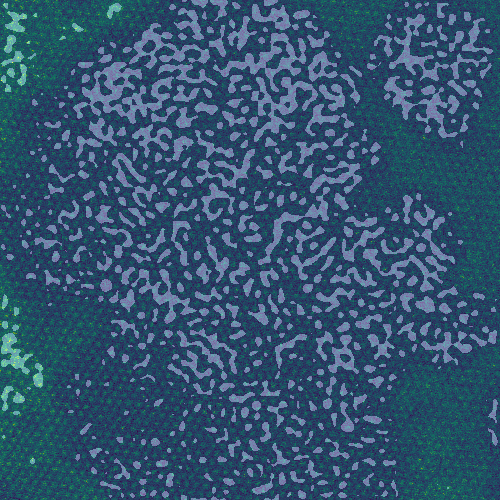

(-0.5, 511.5, 511.5, -0.5)

In [12]:
fig104 = plt.figure(104, figsize=(5,5))
ax = fig104.add_axes([0, 0, 1, 1])

ax.imshow(imgsrc)
ax.imshow(threshI, cmap='gray', alpha=0.3)
ax.axis('off')

### Generate Training data

In [21]:
window_size = 256
window_step = 8
pos_mat = exp.GenerateXYPos(window_size, window_step, imgsrc.shape[0])
print("On image size: ", imgsrc.shape[0], ' by ',  imgsrc.shape[1], ' pixels: ', len(pos_mat), "patches will be generated")

On image size:  512  by  512  pixels:  1024 patches will be generated


In [22]:
immat = exp.imgen(imgsrc, pos_mat, window_size)
labelmat = exp.imgen(labelIm, pos_mat, window_size)


In [29]:
immat2 =  exp.image_preprocessing(immat, 1)
labelmat2 =  exp.label_preprocessing(labelmat, nb_classes = 2)

KeyboardInterrupt: 

## Training the Neural Network model to localize the defects

In [181]:
def model_defect(input_img, nb_classes = 2):
    """Creates a Deep Learning model for defect identification"""
    
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
        
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Convolution2D(nb_classes, (3, 3), activation = 'linear', padding='same')(x)
    x = Convolution2D(nb_classes, (1, 1), activation = 'linear', padding='same')(x)

    output = Activation('softmax')(x)
    
    return Model(input_img, output)

In [133]:
nb_classes = 2
target_size = (256, 256)

X_train, X_test, y_train, y_test = train_test_split(immat2, labelmat2, test_size = 0.2, random_state = 42)

### Trained the model for 50 epochs and got the accuracy for 93.71%

In [183]:
input_img = Input(shape=(target_size[0], target_size[1], 1)) 

model = model_defect(input_img)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
callback_tb = TensorBoard(log_dir='/tmp/AtomGen', histogram_freq=0,
                          write_graph=True, write_images=False)

model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), shuffle=True, verbose = 1)

Train on 819 samples, validate on 205 samples
Epoch 1/50
819/819 [==============================] - 213s 261ms/step - loss: 0.5906 - acc: 0.7286 - val_loss: 0.5791 - val_acc: 0.7270
Epoch 2/50
819/819 [==============================] - 206s 251ms/step - loss: 0.5724 - acc: 0.7288 - val_loss: 0.5628 - val_acc: 0.7270
Epoch 3/50
819/819 [==============================] - 206s 252ms/step - loss: 0.5180 - acc: 0.7333 - val_loss: 0.4879 - val_acc: 0.8255
Epoch 4/50
819/819 [==============================] - 221s 270ms/step - loss: 0.4286 - acc: 0.8123 - val_loss: 0.3928 - val_acc: 0.8240
Epoch 5/50
819/819 [==============================] - 209s 255ms/step - loss: 0.3664 - acc: 0.8438 - val_loss: 0.3556 - val_acc: 0.8404
Epoch 6/50
819/819 [==============================] - 207s 253ms/step - loss: 0.3344 - acc: 0.8545 - val_loss: 0.3145 - val_acc: 0.8646
Epoch 7/50
819/819 [==============================] - 208s 254ms/step - loss: 0.3215 - acc: 0.8601 - val_loss: 0.3029 - val_acc: 0.8699
Ep

#### Saved the model and weights to the folder

In [184]:
model.save(".././Trained_Models/DefectModel50.h5")
model.save_weights(".././Trained_Models/DefectModel_weights50.h5")
print('Saved model and weights to disk.\n')

Saved model and weights to disk.



### Reload the model

In [70]:
model50 = load_model(".././Trained_Models/DefectModel50.h5")

### Apply the trained model to a specific frame to identify defects.

In [94]:
#use frame number to get one specific frame in the movie
fnum = 25
classpred, res = exp.predictDefects(imgdata[fnum], model50, (256,256), nb_classes = 2)

<IPython.core.display.Javascript object>


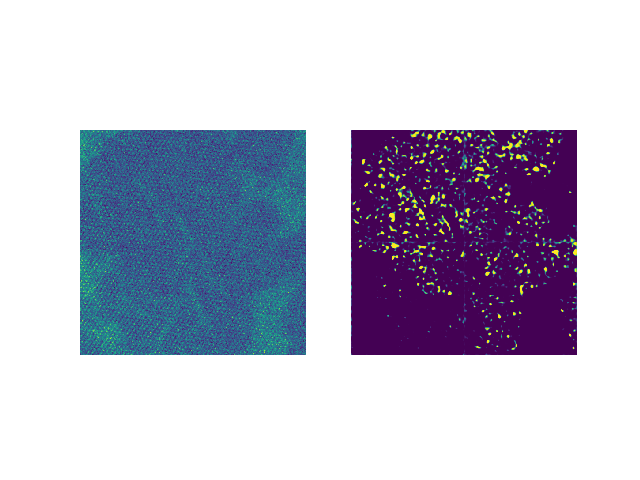

(-0.5, 511.5, 511.5, -0.5)

In [72]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(imgdata[fnum])
ax1.axis('off')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred[1])
ax2.axis('off')

<IPython.core.display.Javascript object>


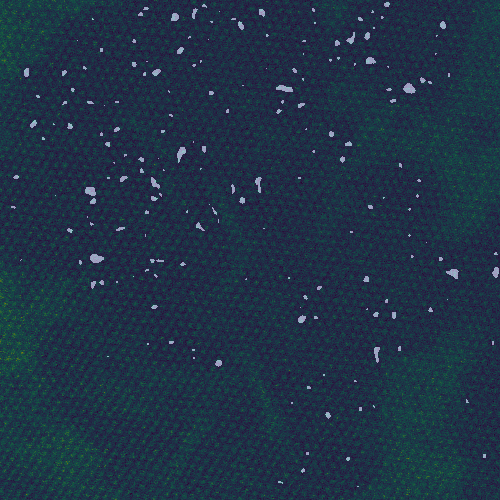

(-0.5, 511.5, 511.5, -0.5)

In [95]:
fig301 = plt.figure(301, figsize=(5,5))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(imgdata[fnum])
ax.imshow(classpred[1] > 0.99, cmap='hot', alpha=0.5)
ax.axis('off')

Extract/Localise defects and plot them for a specific frame 

In [96]:
thresh, defim, defcoord = exp.extractDefects(imgdata[fnum], classpred, softmax_threhold = 0.99, bbox=32)

C:\Users\Sarthak\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


<IPython.core.display.Javascript object>


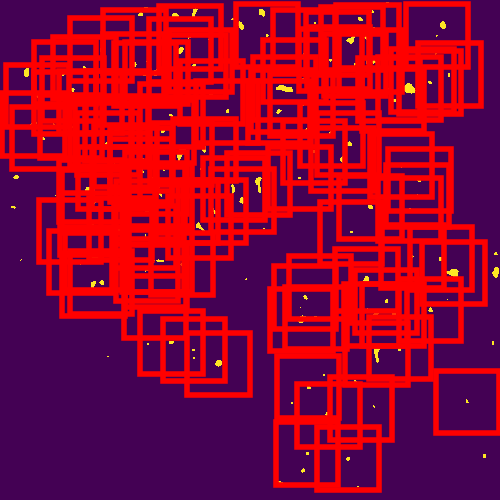

(-0.5, 511.5, 511.5, -0.5)

In [98]:
fig302 = plt.figure(302, figsize=(5,5))
ax = fig302.add_axes([0, 0, 1, 1])
ax.imshow(thresh)
bbox = 32

for point in defcoord:
    startx = int(round(point[0] - bbox))
    endx = startx + bbox*2
    starty = int(round( point[1] - bbox))
    endy = starty + bbox*2
    
    p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor='red', lw=4)
    ax.add_patch(p)
    
ax.axis('off')

In [88]:
bbox=32 # for a 64 x 64 pixels frame for the localized defects - bounding box or bbox = 64 /2 = 32
img = imgdata[25]
defect_list = exp.defectcropped(bbox, img, defcoord)
# convert list to array
defect_list=np.asarray(defect_list)
# reshape the array size to fit the required shape in model_defect_type 
defect_list=defect_list.reshape(defect_list.shape[0],64,64,1)


## Applying the model to the entire movie to localize defects for each frame- 

Save all the ``defect_list`` per frame in movie to the folder "defect_list"

In [128]:
#save all the defect_lists per frame in movie to the folder "defect_list"
directory = '.././defect_list/' + filename[:-4] + '/' 
if not os.path.exists(directory):
    os.makedirs(directory)

bbox = 32

totdefim = np.zeros(shape=(0, bbox*2, bbox*2))
totdefcoord = np.zeros(shape=(0, 2))
totdeffnum = np.zeros(shape=(0,1))


    
for i, img in enumerate(imgdata):
    
    classpred, res = exp.predictDefects(img, model50, (256,256), nb_classes = 2)
    
    thresh, defim, defcoord = exp.extractDefects(img, classpred, softmax_threhold = 0.99, bbox=32)
    
    # record the frame
    nd = len(defim)
    deffnum = np.zeros(shape=(nd,1)) + i
    
    # append to the array
    totdefim = np.append(totdefim, defim, 0) # these are all the defect images for all the frames
    totdefcoord = np.append(totdefcoord, defcoord, 0) # these are all the defect coordinates for all the frames
    totdeffnum = np.append(totdeffnum, deffnum, 0) # these are all the defect frames in the video
    
    # cropping 64 x 64 boxes around the defect coordinates and saving it for later use (frame by frame)
    defect_list = exp.defectcropped(bbox, img, defcoord)
    defect_list = np.asarray(defect_list)
    
    np.save(directory + "defect_list" + str(i) + ".npy" , defect_list)
    
    
np.save(directory + 'defim.npy', totdefim)
np.save(directory + 'defcoord.npy', totdefcoord)
np.save(directory + 'deffnum.npy', totdeffnum)

C:\Users\Sarthak\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


In [6]:
directory = '.././defect_list/' + filename[:-4] + '/'
totdefcoord = np.load(directory + 'defcoord.npy')
totdeffnum = np.load(directory + 'deffnum.npy')
totdefim = np.load(directory + 'defim.npy')

## Load the model trained on theoretical data for predicting defect types

In [12]:
# reload the model to identify the defect type in each defect window of the frame.
model_defect_type=load_model(".././Trained_Models/New_5_8_18_defect_CNN.h5")

In [118]:
#The probabilities for all type of defects in one defect window
model_defect_type.predict(np.array([defect_list[50]]))

array([[3.6422585e-03, 7.7265526e-08, 9.1604674e-01, 8.0156520e-02,
        1.2775839e-04, 2.6803964e-05]], dtype=float32)

## Predicting defect types for all the loaclized defects for all the frames

In [13]:
"""Defects dictionary"""

defects={'Sw':0,'Mo':1,'W2s2':2,'Vw':3,'Vs2':4,'Ws':5}

"""Prediction Model"""
model = model_defect_type

image_size = 64, 64

all_targetclass = np.zeros(shape=(0,1))

path_to_defect_list = ".././defect_list/" + filename[:-4] + '/'

for fnum in range(len(imgdata)):
    
    defect_file = path_to_defect_list + "defect_list" + str(fnum) + ".npy"
    
    defect_list = np.load(defect_file)
    
    defect_list = defect_list.reshape(defect_list.shape[0],64,64,1)
    
    for i in range(defect_list.shape[0]):
        image_file = defect_list[i,:,:,0]
        img = image_file
        img = cv2.resize(img, image_size, interpolation = cv2.INTER_AREA)
        img_i = np.copy(img)
        img = cmap.image_preprocessing_cam(img, image_size)
    
        # predicting using the model
        predictions, target_class = cmap.get_predictions(model, img)
        
        target_class = [[target_class]]       
        
        all_targetclass = np.append(all_targetclass, target_class, 0)

In [14]:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'green', 'darkviolet', 'gold', 'pink', 'red', 'yellow', 'maroon', 'orangered', 'lime', 'darkblue']

### Showing the defect predictions as a movie 

Different defects have different patch colors in the movie (overlayed on the original movie).

In [201]:
mdirectory = '.././Figures/' + filename[:-4] + '/Movie_Prediction/'
if not os.path.exists(mdirectory):
    os.makedirs(mdirectory)

<IPython.core.display.Javascript object>


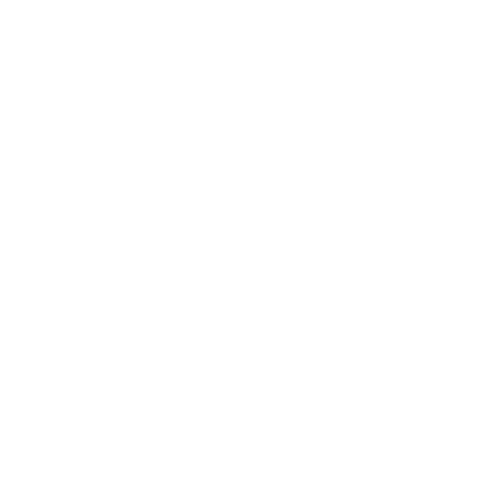

In [202]:
fig403 = plt.figure(403, figsize=(5,5))
ax = fig403.add_axes([0, 0, 1, 1])


for i, img in enumerate(imgdata):
    
    ax.cla()
    ax.imshow(img, cmap ='gray')
    
    
    defcoord = totdefcoord[np.where(totdeffnum == i)[0], :]
    totaltargetclass = all_targetclass[np.where(totdeffnum == i)[0]]
    totaltargetclass = totaltargetclass[:,0]
    
    for i2, point in enumerate(defcoord):
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        
        
        p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor=colors[int(totaltargetclass[i2])], lw=4)
        ax.add_patch(p)
    
    ax.axis('off')
    
    
    fig403.savefig(mdirectory + 'frame_' + str(i) + '.png')

plt.close(fig403)

## Class Activation Maps

### Predicting defect types, defect coordinates and class activation maps 

In [15]:
#no. of the last conv layer(can be found in model.summary() )
last_conv_layer = -4

image_size = 64, 64

CAM_defects = {}

path_to_defect_list = ".././defect_list/" + filename[:-4] + '/'

for fnum in range(len(imgdata)):
    
    defect_file = path_to_defect_list + "defect_list" + str(fnum) + ".npy"
    
    defect_list = np.load(defect_file)
    
    defect_list = defect_list.reshape(defect_list.shape[0],64,64,1)
    
    for i in range(defect_list.shape[0]):
        image_file = defect_list[i,:,:,0]
        img = image_file
        img = cv2.resize(img, image_size, interpolation = cv2.INTER_AREA)
        img_i = np.copy(img)
        img = cmap.image_preprocessing_cam(img, image_size)
    
        # predicting using the model
        predictions, target_class = cmap.get_predictions(model, img)
    
        # gettign softmax weights from model
        softmax_weights = cmap.get_SoftmaxWeights(model)
        conv_out = cmap.get_activation_maps(model, img, last_conv_layer)

        # Class Activation Map
        cam = np.zeros(shape = conv_out.shape[1:3], dtype = np.float32)
    
        for idx, weight in enumerate(softmax_weights[:, target_class]):
            cam += weight * conv_out[idx, :, :]

        cam = (cam - np.amin(cam))/(np.amax(cam) - np.amin(cam))
        cam[np.where(cam < 0.9)] = 0
        cam = cv2.resize(cam, image_size)

        # Extracting Defect class here --- 
        defect_class = cmap.get_defects(defects, target_class)

        # Extracting Defect Coordinates here---
        max_coord = blob_log(cam, min_sigma=0.5)
        x, y = np.transpose(max_coord)[0:2,:]
        coordinates = list(zip(x,y))

        # Compiling everything into Dictionary ---
        dictionary = OrderedDict()    
        dictionary['Image'] = img_i
        dictionary['Defect type'] = defect_class
        dictionary['Defect coordinates'] = coordinates
        dictionary['CAM'] = cam
        CAM_defects['Defect_List_' + str(fnum) + '_%.f' %(i)] = dictionary


Save the dictionary - with Image, Defect type, Defect coordinates and class activation maps to plot later - 

In [16]:
pickle_directory = ".././ClassActivationMap_data/" + filename[:-4] + '/' 
if not os.path.exists(pickle_directory):
    os.makedirs(pickle_directory)

with open(pickle_directory + "CAM_defects.pkl", 'wb') as f:
    pickle.dump(CAM_defects, f)

### Plotting & Saving - Original Images with class activation maps with defect coordinates and types

In [ ]:
"""Plotting a few here ---"""
pickle_directory = ".././ClassActivationMap_data/" + filename[:-4] + '/' 
CAM_defects = {}
CAM_defects = pickle.load(open(pickle_directory + "CAM_defects.pkl", 'rb'))

#favorite_color = pickle.load( open( "save.p", "rb" ) )

"""Select the frame numbers and defect patch numbers that you want to plot"""
fnum = 125

patch_numbers = [0,25, 45, 60, 85]

for i in enumerate(patch_numbers):
    
    img, defect_type, defect_coordinates, cam = CAM_defects['Defect_List_' + str(fnum) + '_' + str(i[1])].values()
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img, cmap = 'gray')
    ax1.set_title('Original image')
    ax2.imshow(cam, cmap = 'jet')
    ax2.imshow(img, cmap = 'gray', alpha = 0.5)
    ax2.set_title('Original image + CAM \n Type: ' + defect_type + '\n Defect coordinates (x, y):' + str(defect_coordinates))
    f.suptitle('Patch Number: ' + str(i[1]))
    

Saving all class activation maps for all the loaclized defects in all the frames of the movie

In [ ]:
"""Saving ALL Class Activation Maps"""

directory = '.././Figures/' + filename[:-4] + '/ClassActivationMaps/'
if not os.path.exists(directory):
    os.makedirs(directory)

for fnum in range(len(imgdata)):
    
    def_per_frame = totdefcoord[np.where(totdeffnum == fnum)[0], :].shape[0]
    
    for i in range(def_per_frame):
    
        img, defect_type, defect_coordinates, cam = CAM_defects['Defect_List_' + str(fnum) + '_' + str(i)].values()
    
        f, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img, cmap = 'gray')
        ax1.set_title('Original image')
        ax2.imshow(cam, cmap = 'jet')
        ax2.imshow(img, cmap = 'gray', alpha = 0.5)
        ax2.set_title('Original image + CAM \n Type: ' + defect_type + '\n Defect coordinates (x, y):' + str(defect_coordinates))
        plt.suptitle('FrameNum: ' + str(fnum) + '   Patch Number: ' + str(i))
        #plt.tight_layout()
    
        plt.savefig(directory + 'FrameNum_' + str(fnum) + '_DefectNum_' + str(i) + '.png')
        plt.close()
        

# Under Progress------------ Putting CAM back into original frames for the entire movie

<IPython.core.display.Javascript object>


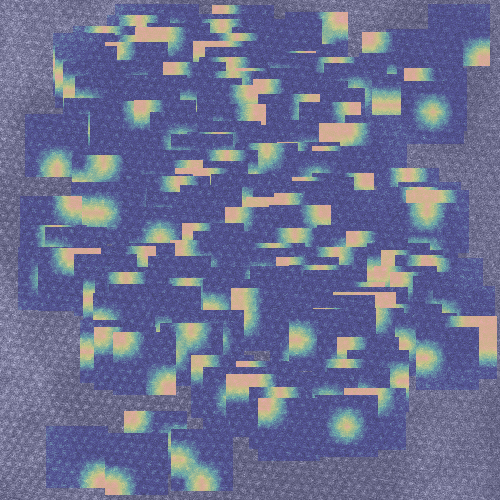

In [263]:
fig403 = plt.figure(403, figsize=(5,5))
ax = fig403.add_axes([0, 0, 1, 1])

bbox = 32

cam_all = np.zeros(shape=(0, bbox*2, bbox*2))
img_all = np.zeros(shape=(0, bbox*2, bbox*2))


for i, img in enumerate(imgdata):
    
    img_copy = np.zeros(shape = img.shape)
    
    defcoord = totdefcoord[np.where(totdeffnum == i)[0], :]
    totaltargetclass = all_targetclass[np.where(totdeffnum == i)[0]]
    totaltargetclass = totaltargetclass[:,0]
    
    for j in range(defcoord.shape[0]):
        image, defect_type, defect_coordinates, cam = CAM_defects['Defect_List_' + str(i) + '_' + str(j)] .values()
        cam = np.reshape(cam, (1,bbox*2, bbox*2))
        image = np.reshape(image, (1,bbox*2, bbox*2))
        cam_all = np.append(cam_all, cam, 0)
        img_all = np.append(img_all, image, 0)
    
    
    for i2, point in enumerate(defcoord):
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2
        
        x = cv2.addWeighted(cam_all[i2],1.0,img_all[i2],0.5,0)
        
        img_copy[startx:endx, starty:endy] = x
        
    ax.cla()
    
    ax.imshow(img_copy, cmap = 'jet', alpha = 0.5)
    ax.imshow(img, cmap ='gray', alpha = 0.5)
    ax.axis('off')
    
    if i ==0:
        break
    
    
    #fig403.savefig(mdirectory + 'frame_' + str(i) + '.png')

#plt.close(fig403)

In [268]:
defcoord2 = totdefcoord[np.where(totdeffnum == 25)[0], :]

defcoord2.shape[0]

114